Defined System: M3System(A=19, B=18, C=1, D=1, E=2, modulus=37)

Available Seed Elements: [0, 1, 4], [0, 1, 8], [0, 1, 16]

Initial PRNG State: [0, 0, 0]

--- Testing Pattern: ([0, 1]) ---
Total generated (before cycle completed): 5000
First 10 generated numbers (A*B Alt):
  [1]: [0, 0, 0]
  [2]: [0, 1, 4]
  [3]: [7, 19, 6]
  [4]: [29, 13, 18]
  [5]: [0, 5, 9]
  [6]: [12, 14, 20]
  [7]: [33, 6, 20]
  [8]: [16, 20, 3]
  [9]: [17, 7, 5]
  [10]: [34, 14, 11]
...



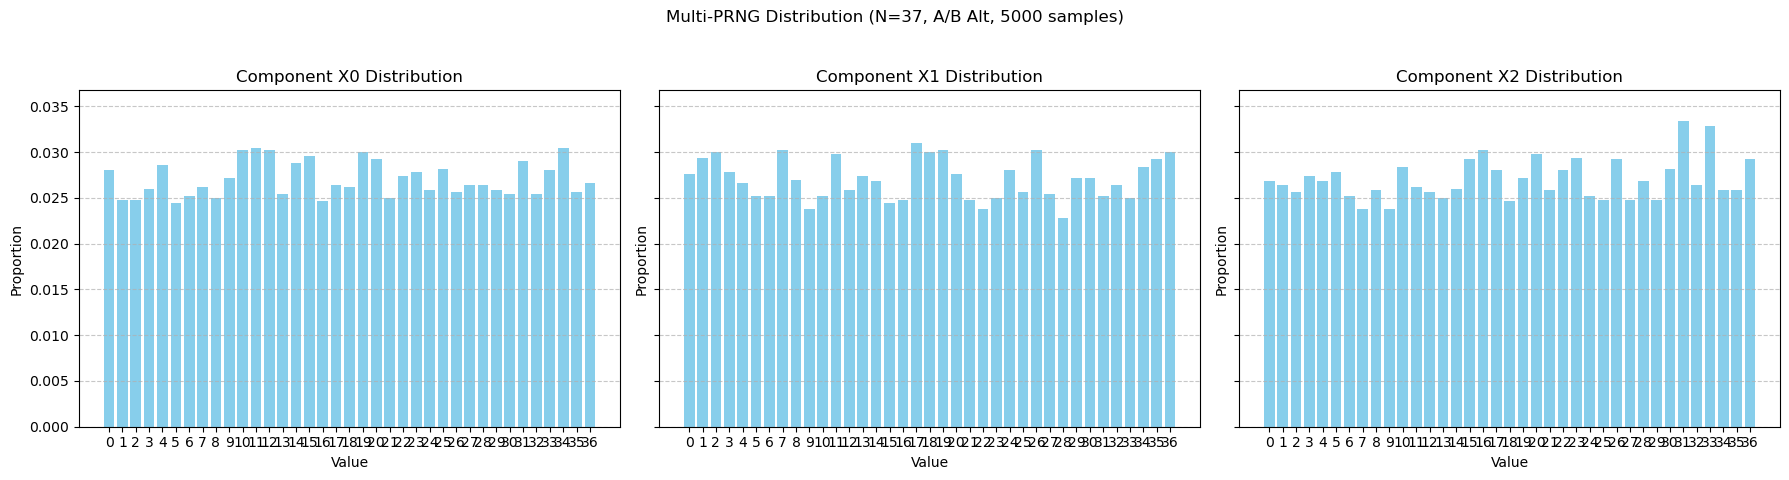

--------------------------------------------------

--- Testing Pattern: ([0, 1, 2]) ---
Generator stopped: Cycle detected! Pre-period: 0, Cycle length: 4104
Total generated (before cycle completed): 4104
Cycle detected! Pre-period length: 0, Cycle length: 4104
First 10 generated numbers (A*B*C Alt):
  [1]: [0, 0, 0]
  [2]: [0, 1, 4]
  [3]: [7, 19, 6]
  [4]: [30, 25, 36]
  [5]: [25, 22, 3]
  [6]: [27, 15, 3]
  [7]: [32, 20, 32]
  [8]: [10, 11, 8]
  [9]: [10, 24, 10]
  [10]: [26, 13, 35]
...



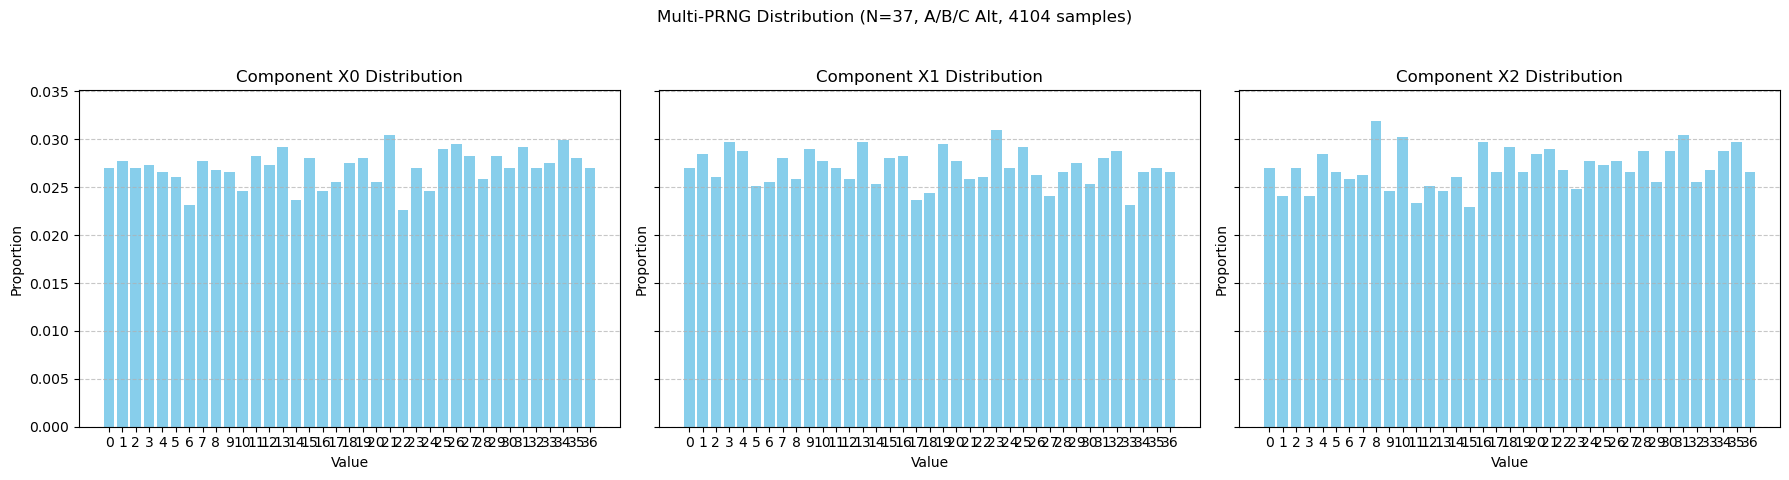

--------------------------------------------------

--- Testing Pattern: Custom Sequence (Pattern: [0, 0, 0, 1, 2]) ---
Total generated (before cycle completed): 5000
First 10 generated numbers (Custom):
  [1]: [0, 0, 0]
  [2]: [0, 1, 4]
  [3]: [15, 11, 7]
  [4]: [32, 15, 23]
  [5]: [26, 7, 12]
  [6]: [1, 6, 26]
  [7]: [15, 25, 9]
  [8]: [0, 7, 6]
  [9]: [16, 34, 27]
  [10]: [26, 0, 30]
...



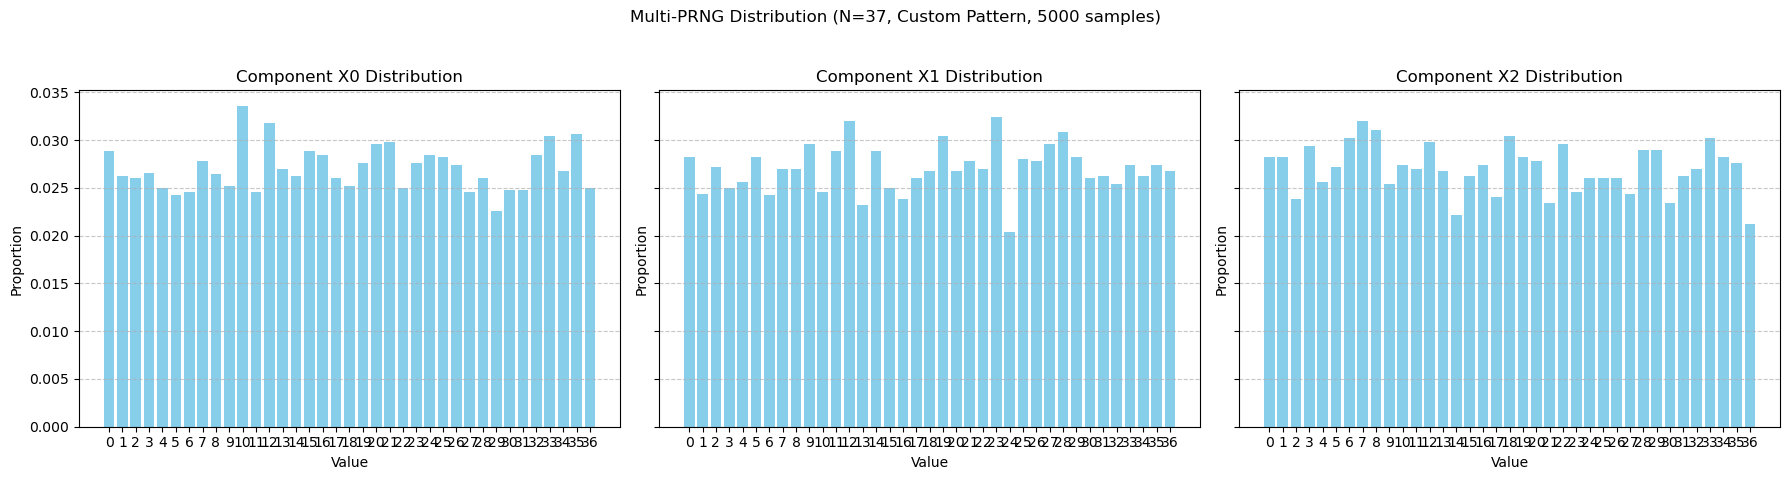

--------------------------------------------------


--- End of Multi-PRNG demonstration ---


In [1]:
import collections.abc
import matplotlib.pyplot as plt
from collections import Counter

class M3System:
    def __init__(self, A, B, C, D, E, modulus):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.E = E
        self.modulus = modulus
        self.identity_element = M3Element([0, 0, 0], self)

    def __str__(self):
        return f"M3System(A={self.A}, B={self.B}, C={self.C}, D={self.D}, E={self.E}, modulus={self.modulus})"

    def get_identity(self):
        return self.identity_element

    def __eq__(self, other):
        if not isinstance(other, M3System):
            return NotImplemented
        return (self.A == other.A and self.B == other.B and self.C == other.C and
                self.D == other.D and self.E == other.E and self.modulus == other.modulus)

    def __hash__(self):
        return hash((self.A, self.B, self.C, self.D, self.E, self.modulus))

class M3Element:
    def __init__(self, x_coords, system):
        if isinstance(x_coords, (list, tuple)) and len(x_coords) == 3:
            x0, x1, x2 = x_coords
        elif isinstance(x_coords, (int, float)) and system:
             x0, x1, x2 = x_coords, x_coords, x_coords
        else:
            raise ValueError("M3Element initialization requires a list/tuple of 3 coordinates or a single value with system.")

        self.x0 = x0 % system.modulus
        self.x1 = x1 % system.modulus
        self.x2 = x2 % system.modulus
        self.system = system
        self.value = (self.x0, self.x1, self.x2) 

    def __mul__(self, other):
        if not isinstance(other, M3Element) or self.system != other.system:
            raise ValueError("Can only multiply M3Element with another M3Element from the same system.")

        s = self.system
        new_x0 = (self.x0 + other.x0 + self.x0 * other.x0 +
                  s.A * self.x1 * other.x1 +
                  s.C * self.x2 * other.x1 +
                  s.B * self.x2 * other.x2) % s.modulus

        new_x1 = (self.x1 + other.x1 + self.x1 * other.x0 +
                  self.x0 * other.x1 +
                  s.D * self.x1 * other.x1 +
                  s.E * self.x1 * other.x2) % s.modulus

        new_x2 = (self.x2 + other.x2 + self.x2 * other.x0 +
                  self.x0 * other.x2 +
                  s.D * self.x2 * other.x1 +
                  s.E * self.x2 * other.x2) % s.modulus

        return M3Element([new_x0, new_x1, new_x2], s)

    def __pow__(self, exponent):
        if not isinstance(exponent, int) or exponent < 0:
            raise ValueError("Exponent must be a non-negative integer.")
        if exponent == 0:
            return self.system.get_identity()
        
        result = self.system.get_identity() 
        base = self

        while exponent > 0:
            if exponent % 2 == 1:
                result = result * base
            base = base * base
            exponent //= 2
        return result

    def __eq__(self, other):
        if not isinstance(other, M3Element):
            return NotImplemented
        return (self.x0 == other.x0 and
                self.x1 == other.x1 and
                self.x2 == other.x2 and
                self.system == other.system)

    def __hash__(self):
        return hash((self.x0, self.x1, self.x2, hash(self.system)))

    def __str__(self):
        return f"[{self.x0}, {self.x1}, {self.x2}]"

    def __repr__(self):
        return self.__str__()

    def to_tuple(self):
        return (self.x0, self.x1, self.x2)
    
    def text(self):
        return self.__str__()


class MultiPRNG(collections.abc.Generator):
    def __init__(self, m3_system: M3System, initial_state: M3Element, seed_elements: list[M3Element], pattern: collections.abc.Sequence[int]):
        """
        Initializes a Multi-PRNG using multiple seed elements and a multiplication pattern,
        with cycle detection capabilities.

        Args:
            m3_system: The M3System instance.
            initial_state: The starting element of the sequence.
            seed_elements: A list of M3Element seeds to use for multiplication.
            pattern: A sequence of integers (indices) defining which seed_element to use
                     at each step of the pattern. The pattern repeats.
        """
        if not isinstance(m3_system, M3System):
            raise TypeError("m3_system must be an instance of M3System.")
        if not isinstance(initial_state, M3Element) or initial_state.system != m3_system:
            raise ValueError("initial_state must be an M3Element belonging to the provided m3_system.")
        if not isinstance(seed_elements, list) or not all(isinstance(s, M3Element) and s.system == m3_system for s in seed_elements):
            raise ValueError("seed_elements must be a list of M3Element instances belonging to the same m3_system.")
        if not seed_elements:
            raise ValueError("seed_elements cannot be empty.")
        if not isinstance(pattern, collections.abc.Sequence) or not all(isinstance(p, int) and 0 <= p < len(seed_elements) for p in pattern):
            raise ValueError("pattern must be a sequence of valid indices for seed_elements.")
        if not pattern:
            raise ValueError("pattern cannot be empty.")

        self._m3_system = m3_system
        self._initial_state = initial_state
        self._current_element = initial_state
        self._seed_elements = seed_elements
        self._pattern = pattern
        self._pattern_idx = 0
        self._step_count = 0 # Tracks the total number of elements yielded so far

        # For cycle detection: stores (element_value_tuple, pattern_index_for_next_step) -> step_count
        self._seen_states = {}
        
        # Cycle detection results
        self._cycle_detected = False
        self._pre_period_length = 0 # Length of the "tail" before the cycle
        self._cycle_length = 0 # Length of the cycle itself

    @property
    def cycle_detected(self) -> bool:
        """Returns True if a cycle was detected during generation."""
        return self._cycle_detected

    @property
    def pre_period_length(self) -> int:
        """Returns the length of the pre-period (tail) if a cycle was detected."""
        return self._pre_period_length

    @property
    def cycle_length(self) -> int:
        """Returns the length of the cycle if a cycle was detected."""
        return self._cycle_length

    def __next__(self):
        if self._cycle_detected:
            # If a cycle has already been detected and processed, stop generating.
            raise StopIteration

        # The 'state' for cycle detection needs to include both the current element
        # and the next pattern index, because (element, pattern_idx) tuple defines the future sequence.
        current_state_key = (self._current_element.to_tuple(), self._pattern_idx)

        if current_state_key in self._seen_states:
            # Cycle detected!
            self._cycle_detected = True
            self._pre_period_length = self._seen_states[current_state_key]
            self._cycle_length = self._step_count - self._pre_period_length
            
            # The current_element is the one that causes the cycle. 
            # We yield it, then stop.
            return_element = self._current_element
            raise StopIteration(f"Cycle detected! Pre-period: {self._pre_period_length}, Cycle length: {self._cycle_length}")
        
        # If not seen, record the current state with its step count
        self._seen_states[current_state_key] = self._step_count
        
        # Yield the current element
        return_element = self._current_element
        
        # Prepare for the next iteration:
        # Determine which seed element to use based on the pattern
        seed_idx = self._pattern[self._pattern_idx]
        multiplier = self._seed_elements[seed_idx]

        # Perform the multiplication: current_element = current_element * multiplier
        self._current_element = self._current_element * multiplier
        
        # Advance the pattern index, wrapping around
        self._pattern_idx = (self._pattern_idx + 1) % len(self._pattern)
        self._step_count += 1 # Increment step count AFTER yielding and processing the current state
        
        return return_element

    def send(self, value):
        raise TypeError("send not supported")

    def throw(self, typ, val=None, tb=None):
        raise TypeError("throw not supported")


# --- Statistics and Visualization ---

def analyze_distribution(numbers: list[M3Element]):
    if not numbers:
        return {"x0": {}, "x1": {}, "x2": {}}
    modulus = numbers[0].system.modulus
    x0_values = [el.value[0] for el in numbers]
    x1_values = [el.value[1] for el in numbers]
    x2_values = [el.value[2] for el in numbers]
    x0_counts = Counter(x0_values)
    x1_counts = Counter(x1_values)
    x2_counts = Counter(x2_values)
    total_numbers = len(numbers)
    x0_dist = {k: v / total_numbers for k, v in x0_counts.items()}
    x1_dist = {k: v / total_numbers for k, v in x1_counts.items()}
    x2_dist = {k: v / total_numbers for k, v in x2_counts.items()}
    return {"x0": x0_dist, "x1": x1_dist, "x2": x2_dist}

def plot_distribution(distribution_data: dict, modulus: int, title: str):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(title)
    components = ['x0', 'x1', 'x2']
    for i, comp in enumerate(components):
        ax = axes[i]
        dist = distribution_data[comp]
        all_possible_values = list(range(modulus))
        counts = [dist.get(val, 0) for val in all_possible_values]
        ax.bar(all_possible_values, counts, width=0.8, color='skyblue')
        ax.set_title(f'Component {comp.upper()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Proportion')
        ax.set_xticks(all_possible_values)
        ax.set_ylim(0, max(counts) * 1.1 if counts else 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    modulus = 37
    my_system = M3System(A=modulus//2+1, B=modulus//2, C=1, D=1, E=2, modulus=modulus)
    print(f"Defined System: {my_system}\n")

    seed_a = M3Element([0, 1, 4], my_system)
    seed_b = M3Element([0, 1, 8], my_system)
    seed_c = M3Element([0, 1, 16], my_system)
    all_seeds = [seed_a, seed_b, seed_c]
    print(f"Available Seed Elements: {', '.join(s.text() for s in all_seeds)}\n")

    initial_prng_state = M3Element([0, 0, 0], my_system)
    print(f"Initial PRNG State: {initial_prng_state.text()}\n")

    pattern_ab_alt = [0, 1]
    pattern_abc_seq = [0, 1, 2]
    pattern_custom = [0, 0, 0, 1, 2]

    # --- Test 1: Simple alternation A*B ---
    print(f"--- Testing Pattern: ({pattern_ab_alt}) ---")
    multi_prng_ab = MultiPRNG(my_system, initial_prng_state, all_seeds, pattern_ab_alt)
    
    generated_numbers_ab = []
    try:
        for _ in range(5000): # Try to generate up to 5000 numbers
            generated_numbers_ab.append(next(multi_prng_ab))
    except StopIteration as e:
        print(f"Generator stopped: {e}")
    
    print(f"Total generated (before cycle completed): {len(generated_numbers_ab)}")
    if multi_prng_ab.cycle_detected:
        print(f"Cycle detected! Pre-period length: {multi_prng_ab.pre_period_length}, Cycle length: {multi_prng_ab.cycle_length}")
    
    print(f"First 10 generated numbers (A*B Alt):")
    for i, num_elem in enumerate(generated_numbers_ab[:10]):
        print(f"  [{i+1}]: {num_elem.text()}")
    print("...\n")
    distribution_ab = analyze_distribution(generated_numbers_ab)
    plot_distribution(distribution_ab, my_system.modulus, 
                      f"Multi-PRNG Distribution (N={my_system.modulus}, A/B Alt, {len(generated_numbers_ab)} samples)")
    print("-" * 50 + "\n")

    # --- Test 2: More complex alternation A*B*C ---
    print(f"--- Testing Pattern: ({pattern_abc_seq}) ---")
    multi_prng_abc = MultiPRNG(my_system, initial_prng_state, all_seeds, pattern_abc_seq)
    
    generated_numbers_abc = []
    try:
        for _ in range(5000):
            generated_numbers_abc.append(next(multi_prng_abc))
    except StopIteration as e:
        print(f"Generator stopped: {e}")
    
    print(f"Total generated (before cycle completed): {len(generated_numbers_abc)}")
    if multi_prng_abc.cycle_detected:
        print(f"Cycle detected! Pre-period length: {multi_prng_abc.pre_period_length}, Cycle length: {multi_prng_abc.cycle_length}")
    
    print(f"First 10 generated numbers (A*B*C Alt):")
    for i, num_elem in enumerate(generated_numbers_abc[:10]):
        print(f"  [{i+1}]: {num_elem.text()}")
    print("...\n")
    distribution_abc = analyze_distribution(generated_numbers_abc)
    plot_distribution(distribution_abc, my_system.modulus, 
                      f"Multi-PRNG Distribution (N={my_system.modulus}, A/B/C Alt, {len(generated_numbers_abc)} samples)")
    print("-" * 50 + "\n")

    # --- Test 3: Custom Pattern (e.g., a*a*a*b*c...) ---
    print(f"--- Testing Pattern: Custom Sequence (Pattern: {pattern_custom}) ---")
    multi_prng_custom = MultiPRNG(my_system, initial_prng_state, all_seeds, pattern_custom)
    
    generated_numbers_custom = []
    try:
        for _ in range(5000):
            generated_numbers_custom.append(next(multi_prng_custom))
    except StopIteration as e:
        print(f"Generator stopped: {e}")
    
    print(f"Total generated (before cycle completed): {len(generated_numbers_custom)}")
    if multi_prng_custom.cycle_detected:
        print(f"Cycle detected! Pre-period length: {multi_prng_custom.pre_period_length}, Cycle length: {multi_prng_custom.cycle_length}")

    print(f"First 10 generated numbers (Custom):")
    for i, num_elem in enumerate(generated_numbers_custom[:10]):
        print(f"  [{i+1}]: {num_elem.text()}")
    print("...\n")
    distribution_custom = analyze_distribution(generated_numbers_custom)
    plot_distribution(distribution_custom, my_system.modulus, 
                      f"Multi-PRNG Distribution (N={my_system.modulus}, Custom Pattern, {len(generated_numbers_custom)} samples)")
    print("-" * 50 + "\n")

    print("\n--- End of Multi-PRNG demonstration ---")